#### NumberLink: Using Genetic Algorithm and Wisdom of Crowds

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import defaultdict

#### Global Variables

##### Think of each tuple in the LIST as the number in Numberlink, and the tuples inside each tuple as the start and end points of the number.

##### So in this example:

```python
pairs = [((0, 0), (4, 4)), ((1, 1), (3, 3))]

1 - - - -
- 2 - - -
- - - - -
- - - 2 -
- - - - 1


In [ ]:
#Global variables

population_size = 800 # Size of the population
mutation_rate = 0.1 # x% of the population will be mutated
generations = 2000 # x generations 
stopping_threshold = 300  # Number of generations with no improvement (i.e. our early stopping condition to prevent running forever lmao)
expert_percentage = 0.3 # x% of the population will be experts
num_elites = 10 # Number of elites to keep for next generation

DIRECTIONS = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Right, Down, Left, Up, makes sense? :D

#### Generate a random path given a start and an end coordinate

In [3]:
def generate_random_path(start, end, grid_size, heuristic_weight):
    path = [start]
    current_position = start
    max_attempts = 100  # Prevent infinite loops
    attempt = 0
    
    while current_position != end and attempt < max_attempts:
        possible_moves = []
        for d in DIRECTIONS:
            next_position = (current_position[0] + d[0], current_position[1] + d[1])
            if 0 <= next_position[0] < grid_size and 0 <= next_position[1] < grid_size:
                # Prefer moves that get closer to the end point
                manhattan_dist = abs(next_position[0] - end[0]) + abs(next_position[1] - end[1])
                possible_moves.append((next_position, manhattan_dist))
        
        if possible_moves:
            # Sort by Manhattan distance and prefer moves that get closer to target
            possible_moves.sort(key=lambda x: x[1])
            # Randomly choose to move to the best move or not
            if random.random() < heuristic_weight:
                current_position = possible_moves[0][0]
            else:
                current_position = random.choice(possible_moves)[0]
            path.append(current_position)
        
        attempt += 1
    
    # If we didn't reach the end, try to directly connect
    if current_position != end:
        path.append(end)
    
    return path

In [4]:
def initialize_population(population_size, pairs, grid_size):
    # Sort pairs by Manhattan distance between start and end points
    sorted_pairs = sorted(enumerate(pairs), 
                        key=lambda x: abs(x[1][1][0] - x[1][0][0]) + abs(x[1][1][1] - x[1][0][1]),
                        reverse=True)  # Reverse to handle longest paths first
    
    population = []
    for _ in range(population_size):
        individual = {}
        # Generate paths in order of distance
        for idx, (start, end) in sorted_pairs:
            individual[idx] = generate_random_path(start, end, grid_size, 0.2)
        population.append(individual)
    return population

In [5]:
def fitness(individual, pairs, grid_size):
    grid = np.zeros((grid_size, grid_size), dtype=int)
    overlap_penalties = 0
    path_efficiency_score = 0
    
    # First check for overlaps (primary objective)
    for path_id, path in individual.items():
        for pos in path:
            if grid[pos[0], pos[1]] == 0:
                grid[pos[0], pos[1]] = path_id + 1
            else:
                # Heavy penalty for overlaps
                overlap_penalties += 10
    
    # If no overlaps, reward shorter paths (secondary objective)
    if overlap_penalties == 0:
        for path_id, path in individual.items():
            start, end = pairs[path_id]
            optimal_distance = abs(end[0] - start[0]) + abs(end[1] - start[1])  # Manhattan distance
            actual_distance = len(path) - 1  # -1 because path includes start point
            
            # Small reward for being close to optimal path length
            path_efficiency = optimal_distance / actual_distance if actual_distance > 0 else 0
            path_efficiency_score += path_efficiency
            
        return path_efficiency_score
    
    # If there are overlaps, return negative score
    return -overlap_penalties

#### Crossover Function (Single-point)

In [6]:
def single_point_crossover(parent1, parent2, pairs):
    crossover_point = random.randint(0, len(pairs) - 1)
    child = {}
    for i in range(len(pairs)):
        if i <= crossover_point:
            child[i] = parent1[i]
        else:
            child[i] = parent2[i]
    return child

#### Muatation Function

In [7]:
def mutate(individual, mutation_rate, pairs, grid_size):
    for i in range(len(pairs)):
        if random.random() < mutation_rate:
            individual[i] = generate_random_path(pairs[i][0], pairs[i][1], grid_size, 0.5)
    return individual

#### Finding the best individual in the population

In [8]:
def get_best_individual(population, pairs, grid_size):
    best_individual = population[0]
    best_fitness_score = fitness(best_individual, pairs, grid_size)
    for individual in population:
        current_fitness = fitness(individual, pairs, grid_size)
        if current_fitness > best_fitness_score:
            best_individual = individual
            best_fitness_score = current_fitness
    return best_individual

#### Tournament Selection for parents (can be varied to employ more diversity)

In [9]:
def select_parent(population, pairs, grid_size):
    # Randomly sample 5 individuals from the population
    sample = random.sample(population, 5)  # Adjust sample size as needed
    # Evaluate fitness for the sampled individuals
    sampled_fitness = [fitness(individual, pairs, grid_size) for individual in sample]
    # Select the individual with the best fitness
    best_index = sampled_fitness.index(max(sampled_fitness))  # Max since we want the highest fitness
    return sample[best_index]

#### Using heatmap (most visited cells) to find a 'wisdom' guided path

In [10]:
def generate_influenced_path(start, end, influence_map, grid_size):
    #Generate path that tries to follow cells commonly used by experts
    path = [start]
    current = start
    visited = set([start])
    
    while current != end:
        best_move = None
        best_score = float('-inf')
        
        # Consider each possible move
        for dx, dy in DIRECTIONS:
            next_pos = (current[0] + dx, current[1] + dy)
            if (0 <= next_pos[0] < grid_size and 
                0 <= next_pos[1] < grid_size and 
                next_pos not in visited):
                
                # Score based on:
                # 1. How many experts used this position
                # 2. Distance to goal
                expert_influence = influence_map[next_pos[0]][next_pos[1]]
                distance_to_goal = abs(next_pos[0] - end[0]) + abs(next_pos[1] - end[1])
                score = expert_influence - (0.1 * distance_to_goal)
                
                if next_pos == end:
                    score += 1000  # Strong bonus for reaching end
                    
                if score > best_score:
                    best_score = score
                    best_move = next_pos
        
        # If no valid moves, break and generate random path
        if best_move is None:
            # print("No valid moves found using wisdom")
            return generate_random_path(start, end, grid_size, 0.5)
            
        current = best_move
        path.append(current)
        visited.add(current)
        
        # Prevent infinite loops
        if len(path) > grid_size * grid_size:
            # print("Infinite loop detected")
            return generate_random_path(start, end, grid_size, 0.5)
    
    return path

In [11]:
def aggregate_expert_solutions(experts, pairs, grid_size):
    #For each path_id, create a heat map of commonly used positions
    #What the heatmap means is that the more experts use a position (cell), the higher the value
    influence_maps = defaultdict(lambda: np.zeros((grid_size, grid_size)))
    
    # Build influence map from all experts
    for expert in experts:
        for path_id, path in expert.items():
            for pos in path:
                influence_maps[path_id][pos[0]][pos[1]] += 1
                
    # Use collective wisdom to generate new paths that follow these high-influence areas
    new_paths = {}
    for path_id in range(len(pairs)):
        start, end = pairs[path_id]
        influence_map = influence_maps[path_id]
        
        path = generate_influenced_path(start, end, influence_map, grid_size)
        new_paths[path_id] = path
        
    return new_paths

#### Main GA method with Wisdom of Crowds

In [12]:
def genetic_algorithm_wisdom(population, generations, mutation_rate, pairs, grid_size, stopping_threshold, expert_percentage, all_tests, all_tests_improvement, wisdom_probability=0.2):
    best_fitness = -float('inf')
    generations_no_improvement = 0

    record_all = pd.DataFrame(columns=['Generation', 'Fitness']) # Record keeping of all generations best solution for statistical analysis.
    record_improvement = pd.DataFrame(columns=['Generation', 'Fitness', 'Solution']) # Record keeping generations and solutions when improvement occured for dynamic illustration.

    for generation in range(generations):
        new_population = []
        
        #Identify elite individuals by picking the top 'n' performers
        elites = sorted(population, key=lambda i: fitness(i, pairs, grid_size), reverse=True)[:num_elites]
        new_population.extend(elites)  # Start with elites
        
        new_population = list(elites)  #Start with the elites

        #Create expert group
        num_experts = int(expert_percentage * len(population))
        experts = sorted(population, key=lambda i: fitness(i, pairs, grid_size), reverse=True)[:num_experts]

        # Generate new individuals through crossover
        while len(new_population) < len(population):  # Maintain population size
            parent1 = select_parent(population, pairs, grid_size)  # Select the first parent
            parent2 = select_parent(population, pairs, grid_size)  # Select the second parent
            
            while parent2 == parent1:  # Ensure parents are not the same
                parent2 = select_parent(population, pairs, grid_size)

            # Crossover and mutation
            child = single_point_crossover(parent1, parent2, pairs)
            child = mutate(child, mutation_rate, pairs, grid_size)

            #Wisdom of Crowd
            # Aggregate expert solutions and mix them into the child
            if random.random() < wisdom_probability:
                aggregated_solution = aggregate_expert_solutions(experts, pairs, grid_size)
                # Apply the wisdom-guided paths
                for path_id, path in aggregated_solution.items():
                    if path_id in child:
                        child[path_id] = path

            new_population.append(child)
        
        population = new_population  # Update the population
        
        # Evaluate fitness and update best individual
        current_best_individual = get_best_individual(population, pairs, grid_size)
        current_best_fitness = fitness(current_best_individual, pairs, grid_size)
        
        # Print the fitness for the current generation
        gen_alias = generation + 1
        print(f"Generation {gen_alias}: Best Fitness = {current_best_fitness}")
        temp_df_1 = pd.DataFrame({'Generation': [gen_alias], 
                           'Fitness': [current_best_fitness]})
        record_all = pd.concat([record_all, temp_df_1], ignore_index=True)
        

        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            temp_df_2 = pd.DataFrame({'Generation': [gen_alias], 
                           'Fitness': [best_fitness], 
                           'Solution': [current_best_individual]})
            record_improvement = pd.concat([record_improvement, temp_df_2], ignore_index=True)
            generations_no_improvement = 0
        else:
            generations_no_improvement += 1
        
        if generations_no_improvement >= stopping_threshold:
            print(f"Stopping early at generation {generation + 1} due to no improvement for {stopping_threshold} generations.")
            break
       
    all_tests.append(record_all)
    all_tests_improvement.append(record_improvement)
    return current_best_individual

### Post Run Analytics

#### Static Plot of Final Solution

In [13]:
def plot_this_numberlink(best_individual, pairs, grid_size):
    plt.figure(figsize=(8, 8))
    
    # Create a blank grid
    for path_id, path in best_individual.items():
        # Extract the x and y coordinates of the path
        x_coords, y_coords = zip(*path)
        plt.plot(y_coords, x_coords, linewidth=2)  # Draw the path
    
    # Plot numbers at start and end points based on success
    for i, (start, end) in enumerate(pairs):
        # Check if the path for the current pair reaches the end point
        if end in best_individual[i]:  # If the end point is in the path
            color = 'red'  # Success
        else:
            color = 'green'  # Failure
        
        # Annotate the grid with numbers, colored based on success
        plt.text(start[1], start[0], str(i + 1), color=color, fontsize=12, ha='center', va='center')  # Number at start
        plt.text(end[1], end[0], str(i + 1), color=color, fontsize=12, ha='center', va='center')    # Number at end

    plt.title("Best Solution Visualization")
    plt.xlim(-0.5, grid_size - 0.5)  # Set x-axis limits
    plt.ylim(grid_size - 0.5, -0.5)  # Invert y-axis
    plt.xticks(range(grid_size))
    plt.yticks(range(grid_size))
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')  # Maintain aspect ratio
    plt.show()

#### Statistical Analysis of all Generations

In [14]:
def statistical_analysis(record_all_df, num_runs, test_name):
    all_tests = pd.concat(record_all_df, ignore_index=True)
    max_value = all_tests['Fitness'].max()
    min_value = all_tests['Fitness'].min()
    mean_value = all_tests['Fitness'].mean()
    std_dev = all_tests['Fitness'].std()

    text_summary = ('Max Length: ' + str(max_value) + 
            '\nMin Length: ' + str(min_value) + 
            '\nMean Length: ' + str(mean_value) +
            '\nStd.dev. : ' + str(std_dev))
    
    # Plotting on same plot
    fig, ax = plt.subplots()
    cmap = cm.get_cmap("GnBu", num_runs)
    for i in range(num_runs):
        c = cmap(i)
        l = 'Test ' + str(i)
        ax.plot((record_all_df[i])['Generation'], (record_all_df[i])['Fitness'], color = c, label = l)

    # Grid Lines
    ax.set_facecolor('lightgrey')
    ax.grid(which = 'major', color = 'white', linewidth = 1.2, zorder = 0)
    ax.grid(which = 'minor', color = 'white', linewidth = 0.6, zorder = 0)
    ax.minorticks_on()
    ax.tick_params(which = 'minor', bottom = False, left = False)

    # Details 
    title = 'Solution Cost for Each Generation Across ' + str(num_runs) + ' Runs\n' + str(test_name)
    ax.set_title(title)
    ax.set_ylabel('Solution Cost ', weight = 'bold')
    ax.set_xlabel('Generation No. ', weight = 'bold')

    # Statistical Summary
    x_min, x_max = ax.get_xlim()  # Unpack xlim tuple
    y_min, y_max = ax.get_ylim()  
    plt.text((x_max * 0.5), (y_min * 0.8), text_summary, fontsize = 8, color = 'black',
            bbox=dict(facecolor = 'lightblue', edgecolor='black'))  
    ax.legend()
    plt.show()


In [15]:
def initialize_file_problem(file_name): 
    with open(file_name, 'r') as file:
        lines = file.readlines()
        grid_size = int(lines[0].split("SIZE: ")[1]) # First line in file defines matrix size
        pairs = []
        for index, line in enumerate(lines):
            if index != 0:
                temp = line.split(": ")[1] # Line after denotation
                coordinate_strings = temp.split(", ") # List of coordinates from file as a string; of the form "(0,0), (1,1)"
                pair = []
                for pair_str in coordinate_strings: # Pair looks like "(0,0)"
                    x, y = map(int, pair_str.strip("()\n").split(",")) # Converst from string to tuple
                    pair.append((x, y)) # Append first tuple to pair, which will be a list of tuples
                pairs.append(tuple(pair)) # Pairs will be a list of tuples - of tuples
                
    # Initialize grid with zeros
    grid = np.zeros((grid_size, grid_size), dtype=int)
    
    # Place the pairs on the grid for visualization (optional)
    for idx, (start, end) in enumerate(pairs, start=1):
        grid[start] = idx
        grid[end] = idx
    
    return grid, pairs, grid_size

### Main

##### Static Problem

Starting Genetic Algorithm...
Run 1/1
Generation 1: Best Fitness = -40
Generation 2: Best Fitness = -30
Generation 3: Best Fitness = -10
Generation 4: Best Fitness = -10
Generation 5: Best Fitness = 5.0
Generation 6: Best Fitness = 5.0
Generation 7: Best Fitness = 5.0
Generation 8: Best Fitness = 5.0
Generation 9: Best Fitness = 5.0
Generation 10: Best Fitness = 5.0
Generation 11: Best Fitness = 5.0
Generation 12: Best Fitness = 5.0
Generation 13: Best Fitness = 5.0
Generation 14: Best Fitness = 5.0
Generation 15: Best Fitness = 5.0
Stopping early at generation 15 due to no improvement for 10 generations.
Best Fitness from Run 1: 5.0
Best Overall Fitness: 5.0


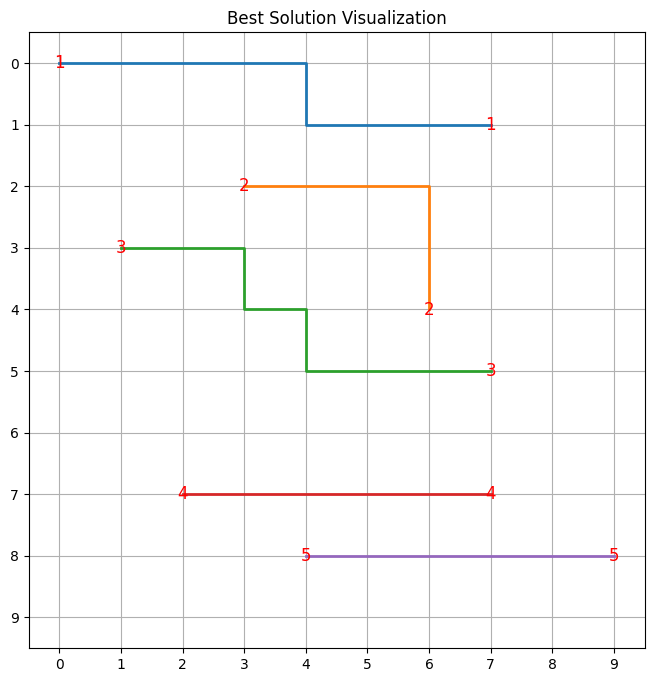

In [16]:
#Static problem
grid_size_static = 10
stopping_threshold_static = 100  # Number of generations with no improvement (i.e. our early stopping condition to prevent running forever lmao)
# Static pairs of coordinates (start, end)
pairs_static = [
    ((0, 0), (1, 7)),  # Pair 1 - will likely need to curve to avoid others
    ((2, 3), (4, 6)),  # Pair 2 - short diagonal near top-left
    ((3, 1), (5, 7)),  # Pair 3 - vertical line that blocks easy paths
    ((7, 2), (7, 7)),  # Pair 4 - crosses the grid horizontally
    ((8, 4), (8, 9))   # Pair 5 - forces others to route around it
]
grid_static = np.zeros((grid_size_static, grid_size_static), dtype=int)
    
# Place the pairs on the grid for visualization (optional)
for i, (start, end) in enumerate(pairs_static, start=1):
    grid_static[start] = i
    grid_static[end] = i


population = initialize_population(population_size, pairs_static, grid_size_static)
num_runs = 1  # Number of runs to perform (testing purposes)
best_overall_individual = None
best_overall_fitness = -float('inf')  # Initialize to a very low number

all_tests_generation_results = []
all_tests_improvement_results = []

print("Starting Genetic Algorithm...")
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    
    # Run the genetic algorithm
    current_best_individual = genetic_algorithm_wisdom(population, generations, mutation_rate, 
                                                       pairs_static, grid_size_static, stopping_threshold_static, 
                                                       expert_percentage, all_tests_generation_results, 
                                                       all_tests_improvement_results)
    
    # Evaluate the fitness of the current best individual
    current_best_fitness = fitness(current_best_individual, pairs_static, grid_size_static)
    
    print(f"Best Fitness from Run {run + 1}: {current_best_fitness}")
    
    # Check if the current run has the best fitness
    if current_best_fitness > best_overall_fitness:
        best_overall_fitness = current_best_fitness
        best_overall_individual = current_best_individual

# After all runs, visualize the best solution found
print(f"Best Overall Fitness: {best_overall_fitness}")
plot_this_numberlink(best_overall_individual, pairs_static, grid_size_static)

#### File Problem

Starting Genetic Algorithm...
Run 1/2
Generation 1: Best Fitness = -180
Generation 2: Best Fitness = -150
Generation 3: Best Fitness = -120
Generation 4: Best Fitness = -100
Generation 5: Best Fitness = -90
Generation 6: Best Fitness = -90
Generation 7: Best Fitness = -70
Generation 8: Best Fitness = -50
Generation 9: Best Fitness = -30
Generation 10: Best Fitness = -30
Generation 11: Best Fitness = -30
Generation 12: Best Fitness = -30
Generation 13: Best Fitness = -30
Generation 14: Best Fitness = -30
Generation 15: Best Fitness = -30
Generation 16: Best Fitness = -30
Generation 17: Best Fitness = -30
Generation 18: Best Fitness = -30
Generation 19: Best Fitness = -30
Generation 20: Best Fitness = -30
Generation 21: Best Fitness = -30
Generation 22: Best Fitness = -30
Generation 23: Best Fitness = -30
Generation 24: Best Fitness = -30
Generation 25: Best Fitness = -30
Generation 26: Best Fitness = -30
Generation 27: Best Fitness = -30
Generation 28: Best Fitness = -30
Generation 29: 

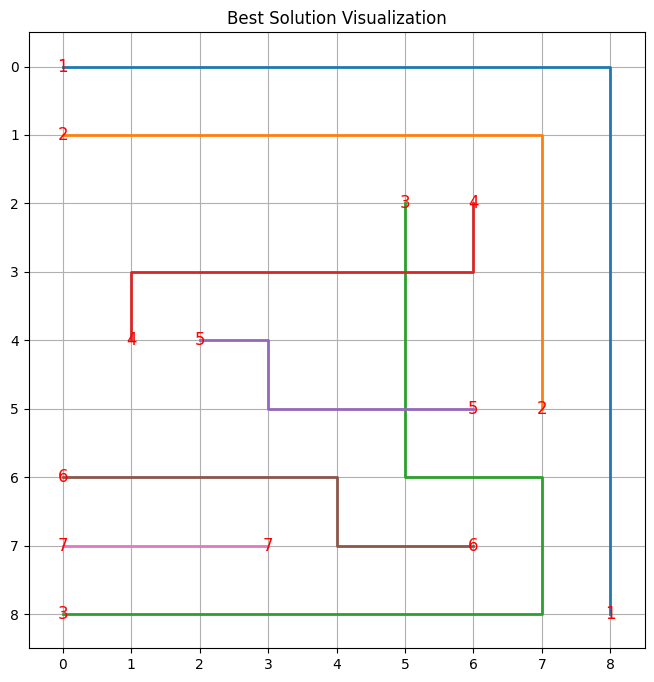

/tmp/ipykernel_9213/3038625378.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("GnBu", num_runs)


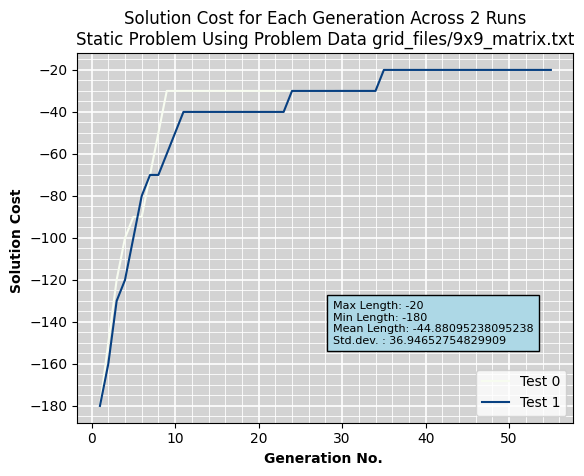

In [ ]:
# File problem

file_name = "grid_files/9x9_matrix.txt"
grid, pairs, grid_size = initialize_file_problem(file_name)
population = initialize_population(population_size, pairs, grid_size)
best_overall_individual = None
best_overall_fitness = -float('inf')  # Initialize to a very low number

all_tests_generation_results = []
all_tests_improvement_results = []

stopping_threshold = 300
num_runs = 2

print("Starting Genetic Algorithm...")
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    
    # Run the genetic algorithm
    current_best_individual = genetic_algorithm_wisdom(population, generations, 
                                                       mutation_rate, pairs, grid_size, 
                                                       stopping_threshold, expert_percentage, 
                                                       all_tests_generation_results,
                                                       all_tests_improvement_results)

    # Evaluate the fitness of the current best individual
    current_best_fitness = fitness(current_best_individual, pairs, grid_size)
    
    print(f"Best Fitness from Run {run + 1}: {current_best_fitness}")
    
    # Check if the current run has the best fitness
    if current_best_fitness > best_overall_fitness:
        best_overall_fitness = current_best_fitness
        best_overall_individual = current_best_individual

# After all runs, visualize the best solution found
print(f"Best Overall Fitness: {best_overall_fitness}")
plot_this_numberlink(best_overall_individual, pairs, grid_size)
test_name = 'Static Problem Using Problem Data ' + file_name
statistical_analysis(all_tests_generation_results, num_runs, test_name)

#### Random Problem

Starting Genetic Algorithm...
Run 1/1
Generation 1: Best Fitness = -10
Generation 2: Best Fitness = 3.7777777777777777
Generation 3: Best Fitness = 3.7777777777777777
Generation 4: Best Fitness = 3.7777777777777777
Generation 5: Best Fitness = 3.7777777777777777
Generation 6: Best Fitness = 3.7777777777777777
Generation 7: Best Fitness = 3.7777777777777777
Generation 8: Best Fitness = 3.7777777777777777
Generation 9: Best Fitness = 3.7777777777777777
Generation 10: Best Fitness = 3.7777777777777777
Generation 11: Best Fitness = 3.7777777777777777
Generation 12: Best Fitness = 3.7777777777777777
Generation 13: Best Fitness = 3.7777777777777777
Generation 14: Best Fitness = 3.7777777777777777
Generation 15: Best Fitness = 3.7777777777777777
Generation 16: Best Fitness = 3.7777777777777777
Generation 17: Best Fitness = 3.7777777777777777
Generation 18: Best Fitness = 3.7777777777777777
Generation 19: Best Fitness = 3.7777777777777777
Generation 20: Best Fitness = 3.7777777777777777
Genera

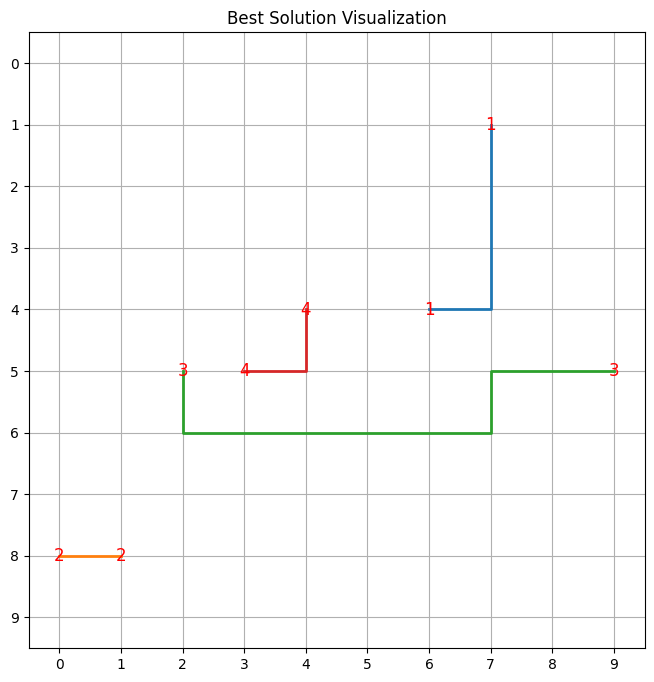

/tmp/ipykernel_9213/3038625378.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("GnBu", num_runs)


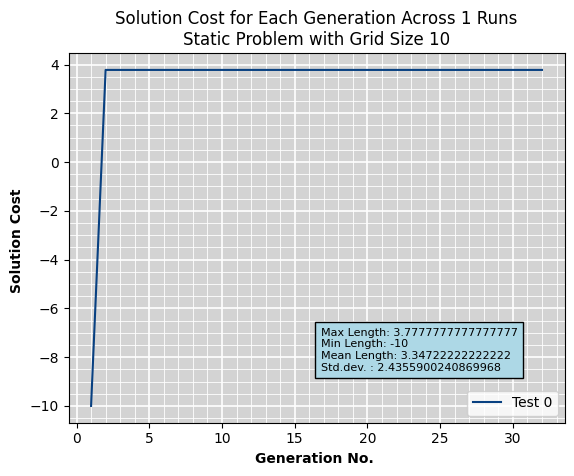

In [18]:
#Random Problem Initialization
grid_size_random = 10
# We have 10 pairs of start and end points (i.e. 10 number pairs to find paths between)
pairs_random = [((random.randint(0, grid_size_random-1), random.randint(0, grid_size_random-1)),
          (random.randint(0, grid_size_random-1), random.randint(0, grid_size_random-1)))
         for _ in range(4)]
population = initialize_population(population_size, pairs_random, grid_size_random)
num_runs = 1  # Number of runs to perform (testing purposes)
best_overall_individual = None
best_overall_fitness = -float('inf')  # Initialize to a very low number
stopping_threshold = 30

all_tests_generation_results = []
all_tests_improvement_results = []

print("Starting Genetic Algorithm...")
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    
    # Run the genetic algorithm
    current_best_individual = genetic_algorithm_wisdom(population, generations, 
                                                        mutation_rate, pairs_random, 
                                                        grid_size_random, stopping_threshold, 
                                                        expert_percentage, 
                                                        all_tests_generation_results,
                                                        all_tests_improvement_results)
    # Evaluate the fitness of the current best individual
    current_best_fitness = fitness(current_best_individual, pairs_random, grid_size_random)
    
    print(f"Best Fitness from Run {run + 1}: {current_best_fitness}")
    
    # Check if the current run has the best fitness
    if current_best_fitness > best_overall_fitness:
        best_overall_fitness = current_best_fitness
        best_overall_individual = current_best_individual

# After all runs, visualize the best solution found
print(f"Best Overall Fitness: {best_overall_fitness}")
plot_this_numberlink(best_overall_individual, pairs_random, grid_size_random)

# Visualize testing analysis
test_name = 'Static Problem with Grid Size ' + str(grid_size_random)
statistical_analysis(all_tests_generation_results, num_runs, test_name)
